## Import necessary packages


In [ ]:
import os
import sys
import time
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from skimage.io import imshow
from skimage.transform import resize
# from skimage.morphology import label
# from skimage.feature import structure_tensor
from sklearn.model_selection import train_test_split
# from PIL import Image, ImageDraw
# import cv2

import tensorflow as tf
from torch.utils import data
import torchvision.transforms as transforms
from tensorflow import keras

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adamax, Ftrl
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from tensorflow.keras.layers.experimental.preprocessing import Resizing

## load data


### check image dimension

In [2]:
# Original Images
#img = load_img('../data_augment2/Ankle_A01angle15trial2_12_62590_P4R11.jpg', color_mode='grayscale')

# WHS Images
img = load_img('../data_augment_weight_dist_no_apo/AnkleHough_A01angle10trial1_1000_1476.jpg', color_mode='grayscale')

height = img.size[1]
width = img.size[0]

print('height:', height, '  ', 'width:', width)


height: 180    width: 400


### set up the image frames

In [3]:
# Original Images
#Total_size = 8550

# WHS Images
Total_size = 6000

#use a small piece to debug
#Total_size = int(Total_size*0.05)

### set up image upload functions

In [4]:
#upload function
#normalize the ref using max values
pos_limit = 180
angle_limit = 18


class CustomDataFolder(data.Dataset):
    
    def __init__(self, path, transform = None):
        self._path = path
        self._image_paths = os.listdir(path)
        self._transform = transform
        
    def __getitem__(self, index):
        image = Image.open(os.path.join(self._path, self._image_paths[index]))
        label1 = float(float(os.path.basename(self._image_paths[index]).split('_')[2])/pos_limit/100)
        label2 = float((os.path.basename(self._image_paths[index]).split('_')[3]).split('.')[0])/angle_limit/1000      
        

        #print(label)
        if self._transform:
            image = self._transform(image)
        return image, label1, label2
    
    def __len__(self):
        return len(self._image_paths)

### image transform

In [5]:
#You may need to find the dir of your images in terminal and enter:
#.DS_Store rm .amlignore rm .amlignore.amltmp


#rescale the image to Unet fashion
im_height = 512
im_width = 512

scale_x = im_height/height
scale_y = im_width/width


#transform the data to tensor so that you can use pytorch
transform = transforms.Compose([
    transforms.Resize((im_height, im_width)),
    transforms.ToTensor()
])

# Original
#trainset = CustomDataFolder('../data_augment2', transform)

#WHS
trainset = CustomDataFolder('../data_augment_weight_dist_no_apo', transform)

### check the data

(0.05555555555555555, 0.082)

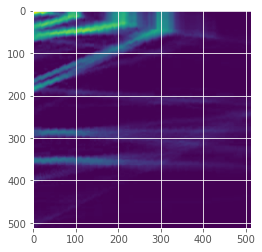

In [6]:
#check
tensor_exam = trainset[0][0]
pic_exam = tensor_exam.cpu().numpy()
plt.imshow(pic_exam[1])
im_height = pic_exam[0].shape[0]
im_width = pic_exam[0].shape[1]
im_height, im_width

#check if the ref numbers make sense
trainset[0][1], trainset[0][2]

### upload data

In [8]:
#initialize the dataset
print("Total no. of aponeurosis images = ", Total_size)
X = np.zeros((Total_size, im_height, im_width, 3), dtype=np.float32)
y = np.zeros((Total_size, 2), dtype=np.float32)


#fill the dataset
for n in range(Total_size):
    tensor_n = trainset[n][0]
    pic_n = tensor_n.cpu().numpy()
    pos = trainset[n][1]
    angle = trainset[n][2]
    
    X[n] = pic_n.transpose()
    y[n] = np.array([pos, angle])

Total no. of aponeurosis images =  6000


### expand dimensions

In [9]:
# If you use monochromatic images, you may need it.
#X = np.expand_dims(X, axis=3)
#y = np.expand_dims(y, axis=3)
X.shape, y.shape

((6000, 512, 512, 3), (6000, 2))

### split data to training and testing (validate) sets

In [ ]:
# Split data into training and testing
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1) # i.e. 90% training / 10% test split


batch_size = 20
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size)



## GPU Preparation

In [13]:
# Check gpu
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  4


In [ ]:
# Set up gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      #tf.config.LogicalDeviceConfiguration(memory_limit=1024)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## Create Model

### define SCNN structure

In [15]:
# Convolution block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


# Convolution block
def conv2d_unit(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    
    return x


# Create model
def get_simple_net(input_img, n_filters = 16, dropout = 0.9, batchnorm = True):
    """Function to define the UNET Model"""
    """Output is refitted"""
    
    # Contracting Path
    c1 = conv2d_unit(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    
    #pt = c1
    
    p1 = MaxPooling2D((2, 2))(c1)
    pt = Dropout(dropout)(p1)

    #c2 = conv2d_block(p1, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    #p2 = MaxPooling2D((2, 2))(c2)
    #pt = Dropout(dropout)(p2)
    

    #c3 = conv2d_block(p1, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    #p3 = MaxPooling2D((2, 2))(c2)
    #p3 = Dropout(dropout)(p2)



    outputs0 = Conv2D(1, (1, 1), activation='relu')(pt)
    flatten = Flatten(name='flatten')(outputs0)

    #flatten = Flatten(name='flatten')(pt)

    outputs1 = Dense(64, activation='relu', name='output1')(flatten)
    outputs = Dense(2, activation='sigmoid', name='output')(outputs1)
    
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Compute Intersection over union (IoU), a measure of labelling accuracy
# NOTE: This is sometimes also called Jaccard score
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

# MSE
def myMSE(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

### create strategy

In [ ]:
# Create a MirroredStrategy.
#tf.debugging.set_log_device_placement(True)
#gpus = tf.config.list_logical_devices('GPU')
#strategy = tf.distribute.MirroredStrategy(gpus)
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
#print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.

    input_img = Input((im_height, im_width, 3), name='img')
    model = get_simple_net(input_img, n_filters=16, dropout=0.80, batchnorm=True)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["accuracy", IoU])

# Turn-off the AutoShardPolicy
#options = tf.data.Options()
#options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF

#train_data = train_data.with_options(options)
#test_data = test_data.with_options(options)


In [17]:
# Set up some parameters
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.2, patience=4, min_lr=0.00001, verbose=1),
    ModelCheckpoint('simple_model_save_h.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger('simple_model_weights_h.csv', separator=',', append=False)
]

In [ ]:
# Summary of the model structure
model.summary()

## Training and Testing

In [ ]:
# Train
results = model.fit(X_train, y_train, batch_size=20, epochs=10, callbacks=callbacks, validation_data=(X_valid, y_valid))


In [ ]:
# Obtaining training and testing sets
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

In [22]:
# Organize the data 
train_len, test_len = len(preds_train), len(preds_val)
#for training data
y_train_ref_p = np.zeros((train_len, 1), dtype=np.float32) #posiition
y_train_ref_a  = np.zeros((train_len, 1), dtype=np.float32) #angle
y_train_predict_p = np.zeros((train_len, 1), dtype=np.float32) #posiition
y_train_predict_a  = np.zeros((train_len, 1), dtype=np.float32) #angle
#for testing data
y_test_ref_p = np.zeros((test_len, 1), dtype=np.float32) #posiition
y_test_ref_a  = np.zeros((test_len, 1), dtype=np.float32) #angle
y_test_predict_p = np.zeros((test_len, 1), dtype=np.float32) #posiition
y_test_predict_a  = np.zeros((test_len, 1), dtype=np.float32) #angle

for n in range(train_len):
    y_train_ref_p[n] = y_train[n][0]
    y_train_ref_a[n] = y_train[n][1]
    y_train_predict_p[n] = preds_train[n][0]
    y_train_predict_a[n] = preds_train[n][1]

for n in range(test_len):
    y_test_ref_p[n] = y_valid[n][0]
    y_test_ref_a[n] = y_valid[n][1]
    y_test_predict_p[n] = preds_val[n][0]
    y_test_predict_a[n] = preds_val[n][1]



In [ ]:
# MSE
mse_p = myMSE(y_test_predict_p*pos_limit, y_test_ref_p*pos_limit)
print(mse_p)

mse_a = myMSE(y_test_predict_a*angle_limit, y_test_ref_a*angle_limit)
print(mse_a)

## Save data

In [24]:
timeStamp = np.array([datetime.datetime.now().strftime("%m/%d/%Y/%H:%M:%S")])
dfTime = pd.DataFrame(timeStamp)

mse_p_t = pd.DataFrame([mse_p])
mse_a_t = pd.DataFrame([mse_a])
dfMse_p = pd.DataFrame(np.array(mse_p_t))
dfMse_a = pd.DataFrame(np.array(mse_a_t))

dfTrainLoss = pd.DataFrame(results.history["loss"])
dfTestLoss = pd.DataFrame(results.history["val_loss"])

dfY_train_p = pd.DataFrame(np.array(y_train_predict_p*pos_limit))
dfY_train_p_ref = pd.DataFrame(np.array(y_train_ref_p*pos_limit))
dfY_test_p = pd.DataFrame(np.array(y_test_predict_p*pos_limit))
dfY_test_p_ref = pd.DataFrame(np.array(y_test_ref_p*pos_limit))

dfY_train_a = pd.DataFrame(np.array(y_train_predict_a*angle_limit))
dfY_train_a_ref = pd.DataFrame(np.array(y_train_ref_a*angle_limit))
dfY_test_a = pd.DataFrame(np.array(y_test_predict_a*angle_limit))
dfY_test_a_ref = pd.DataFrame(np.array(y_test_ref_a*angle_limit))

df_all = pd.concat([dfTime, dfMse_p, dfMse_a, dfTrainLoss, dfTestLoss, dfY_train_p, dfY_train_p_ref, dfY_test_p, dfY_test_p_ref, dfY_train_a, dfY_train_a_ref, dfY_test_a, dfY_test_a_ref], ignore_index=True, axis=1)
df_all.columns = ["time", "MSE_p", "MSE_a", "TrainLoss", "TestLoss", "y_train_p", "y_train_p_groundtruth", "y_test_p", "y_test_p_groundtruth", "y_train_a", "y_train_a_groundtruth", "y_test_a", "y_test_a_groundtruth"]

In [43]:
saveName_pos = 'SCNN_res' + '.csv'
df_all.to_csv(saveName_pos)